# Compute mean and variance for each program
Look at different methods: expected from sections, expected from primary mode.
Also shows proportions of distance traveled in each mode and an estimate of accuracy for sensing.
The program specific and true mode specific bar charts come from this notebook.
Makes a percent error table

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from uuid import UUID

import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/mallen2/alternate_branches/eval-compatible-server/e-mission-server')

import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.decorations.trip_queries as esdtq
import emission.core.wrapper.user as ecwu

import confusion_matrix_handling as cm_handling
from confusion_matrix_handling import MODE_MAPPING_DICT
import get_EC
import helper_functions as hf

import sklearn.model_selection as skm

from sklearn.model_selection import KFold
from sklearn import linear_model

METERS_TO_MILES = 0.000621371 # 1 meter = 0.000621371 miles
ECAR_PROPORTION = 0 #0.01 #~1% of cars on the road are electric.
DROVE_ALONE_TO_SHARED_RIDE_RATIO = 1

df_EI = pd.read_csv(r'Public_Dashboard/auxiliary_files/energy_intensity.csv') # r stands for raw string, only matters if the path is on Windows

storage not configured, falling back to sample, default configuration
URL not formatted, defaulting to "Stage_database"
Connecting to database URL localhost


In [2]:
# If you've run store_expanded_labeled_trips.ipynb and want to save time vs the cell below
%store -r expanded_labeled_trips

In [ ]:
'''import database_related_functions as drf  # all the emission server functions for this notebook are in here.
user_list, os_map, uuid_program_map = drf.get_participants_programs_and_operating_systems()
#print(len(user_list), len(os_map), len(uuid_program_map))

# Takes 6 to 14 minutes on Macbook Pro for all ceo data + stage + prepilot.
# Takes ~ 1 min 45 s to 2 min 45 s on Macbook Pro for all ceo data up to May 2022.
expanded_labeled_trips = drf.get_expanded_labeled_trips(user_list)
expanded_labeled_trips['os'] = expanded_labeled_trips.user_id.map(os_map)
expanded_labeled_trips['program'] = expanded_labeled_trips['user_id'].map(uuid_program_map)

expanded_labeled_trips = expanded_labeled_trips.drop(labels = ['source', 'end_fmt_time', 'end_loc', 'raw_trip',
    'start_fmt_time', 'start_loc','start_local_dt_year', 'start_local_dt_month', 'start_local_dt_day',
    'start_local_dt_hour', 'start_local_dt_minute', 'start_local_dt_second',
    'start_local_dt_weekday', 'start_local_dt_timezone',
    'end_local_dt_year', 'end_local_dt_month', 'end_local_dt_day',
    'end_local_dt_hour', 'end_local_dt_minute', 'end_local_dt_second',
    'end_local_dt_weekday', 'end_local_dt_timezone'], axis = 1)

expanded_labeled_trips['distance_miles'] = expanded_labeled_trips.distance*METERS_TO_MILES

# Group together the prepilot participants
prepilot_list = ['84Q9SsrH','cwZazZLJ','CudLAeg8','sxxcLqbK','Q8T7QTXK','5KEGHHuf','e9MaNVU7','7c797MRD','rhBZukxY','k36cxmfA','FmxVf8u6','F3jxHLSW']
expanded_labeled_trips['program'] = expanded_labeled_trips.program.replace(prepilot_list, "prepilot")'''

In [3]:
unit_dist_MCS_df = pd.read_csv("unit_distance_MCS.csv").set_index("moment")
energy_dict = cm_handling.get_energy_dict(df_EI, units='MWH')

sensed_car_EI = hf.find_sensed_car_energy_intensity(energy_dict, ECAR_PROPORTION, DROVE_ALONE_TO_SHARED_RIDE_RATIO)
energy_dict.update({"Car, sensed": sensed_car_EI})

In [24]:
# how much do sensed modes for custom labels contribute to the total expected energy consumption?
def drop_non_custom_labels(df,custom_mode_trip_list):
    df = df.copy()
    # drop the indices where the _id is in custom_mode_trip_list
    #df = df.drop(df[df._id.isin(custom_mode_trip_list)].index)
    df = df[df._id.isin(custom_mode_trip_list)]
    return df

custom_mode_trip_list = []
for i,ct in expanded_labeled_trips.iterrows():
    mode = ct['mode_confirm']
    if mode == np.nan or type(mode) == float: 
        continue
    elif (('car' in mode) & ('alone' in mode)) or (mode == 'drove_alone'):
        continue
    elif (('car' in mode) & ('with others' in mode)) or mode == 'shared_ride':
        continue
    elif mode not in MODE_MAPPING_DICT:
        custom_mode_trip_list.append(ct['_id'])

print(len(custom_mode_trip_list))

android_EI_moments_df = cm_handling.get_conditional_EI_expectation_and_variance(android_confusion,energy_dict)
ios_EI_moments_df = cm_handling.get_conditional_EI_expectation_and_variance(ios_confusion,energy_dict)
os_EI_moments_map = {'ios': ios_EI_moments_df, 'android': android_EI_moments_df}
energy_consumption_from_sections_df= get_EC.compute_all_EC_values(
    drop_non_custom_labels(expanded_labeled_trips, custom_mode_trip_list),
    unit_dist_MCS_df,energy_dict,android_EI_moments_df,ios_EI_moments_df, \
    0, print_info=False)
print(energy_consumption_from_sections_df.expected.sum(),energy_consumption_from_sections_df.user_labeled.sum())

866
Computing energy consumption for each trip.
Using EI length covariance = 0.
6.096404570381868 0


In [4]:
expanded_labeled_trips = hf.drop_unwanted_trips(expanded_labeled_trips,drop_not_a_trip=False) # nans are treated as not a trip.
#expanded_labeled_trips = hf.drop_custom_labels(expanded_labeled_trips, MODE_MAPPING_DICT)
expanded_labeled_trips = hf.get_primary_modes(expanded_labeled_trips,energy_dict,MODE_MAPPING_DICT)

Dropping user labeled AIR trips and trips with no OS.
Dropped 93 trips with no sensed sections.


In [5]:
print(expanded_labeled_trips.program.value_counts().to_latex())
print(f"all: {len(expanded_labeled_trips)}")

\begin{tabular}{lr}
\toprule
{} &  program \\
\midrule
cc       &    28768 \\
pc       &    17880 \\
fc       &    11744 \\
stage    &    10715 \\
sc       &     9092 \\
vail     &     6348 \\
4c       &     5262 \\
prepilot &     2425 \\
\bottomrule
\end{tabular}

all: 92234


In [5]:
expanded_labeled_trips.distance_miles.sum()

519356.5272555127

In [6]:
# How far did people travel in each labeled mode?
all_mode_distances = expanded_labeled_trips.groupby('mode_confirm').sum().distance_miles
all_mode_distance_proportions = all_mode_distances.divide(sum(expanded_labeled_trips.distance_miles))
print(all_mode_distance_proportions.sort_values(ascending=False)[0:10].round(4).to_latex())

\begin{tabular}{lr}
\toprule
{} &  distance\_miles \\
mode\_confirm      &                 \\
\midrule
shared\_ride       &          0.4541 \\
drove\_alone       &          0.2452 \\
pilot\_ebike       &          0.1288 \\
not\_a\_trip        &          0.0428 \\
walk              &          0.0323 \\
bus               &          0.0302 \\
bike              &          0.0158 \\
train\_to airplane &          0.0107 \\
train             &          0.0087 \\
taxi              &          0.0064 \\
\bottomrule
\end{tabular}



In [36]:
all_mode_distance_proportions.sort_values(ascending=False)[0:10].round(4)

mode_confirm
shared_ride          0.4541
drove_alone          0.2452
pilot_ebike          0.1288
not_a_trip           0.0428
walk                 0.0323
bus                  0.0302
bike                 0.0158
train_to airplane    0.0107
train                0.0087
taxi                 0.0064
Name: distance_miles, dtype: float64

Text(0.5, 1.0, 'User labeled mode proportions for CanBikeCO data')

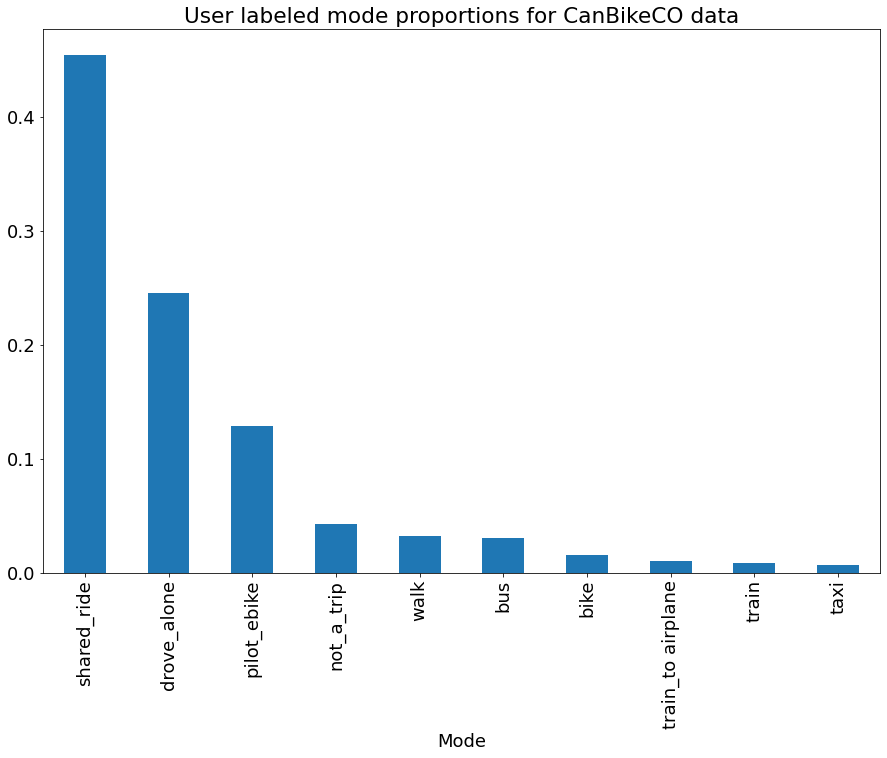

In [35]:
plt.figure()
plt.rcParams.update({'font.size': 18})
all_mode_distance_proportions.sort_values(ascending=False)[0:10].plot(kind='bar')
plt.xlabel('Mode')
plt.title('User labeled mode proportions for CanBikeCO data')

### Rough estimates of accuracy

In [ ]:
# What percent of primary mode predictions is correct?
# LENIENT MATCHING
main_mode_confirms = ['drove_alone','shared_ride','walk','pilot_ebike','bus','bike','train','taxi','free_shuttle', 'not_a_trip']
main_modes_df = expanded_labeled_trips[expanded_labeled_trips.mode_confirm.isin(main_mode_confirms)].copy()
main_modes_df = main_modes_df[main_modes_df.mode_confirm.notna()]

match_count = 0
for _,ct in main_modes_df.iterrows():
    if (ct['primary_mode'] == 'car') and (ct['mode_confirm'] in ['shared_ride', 'taxi', 'drove_alone']):
        match_count += 1
    elif (ct['primary_mode'] == 'bicycling') and (ct['mode_confirm'] == 'pilot_ebike'):
        match_count += 1
    elif (ct['primary_mode'] == 'bus') and (ct['mode_confirm'] == 'free_shuttle'):
        match_count += 1
    elif MODE_MAPPING_DICT[ct['primary_mode']] == MODE_MAPPING_DICT[ct['mode_confirm']]:
        match_count += 1

# The version below doesn't count a car prediction as correct for shared ride.
#sum(main_modes_df.mode_confirm.map(MODE_MAPPING_DICT)== main_modes_df.primary_mode.map(MODE_MAPPING_DICT))/len(main_modes_df)

print(f"Accuracy by count: {match_count/len(main_modes_df)*100}")  # 65.75% if we exclude not_a_trip, 63.50% if we include not_a_trip
# What fraction of the distance are we correctly predicting?

# Note: MODE_MAPPING_DICT["no_sensed"] == MODE_MAPPING_DICT["not_a_trip"]   # both give 'Not a Trip'

match_distance = 0
for _,ct in main_modes_df.iterrows():
    if len(ct['section_modes']) == 0:
        print(f"No sections sensed for a {ct['mode_confirm']} trip.")
    for i,s in enumerate(ct['section_modes']):
        if (s == 'car') and (ct['mode_confirm'] in ['shared_ride', 'taxi','drove_alone']):
            match_distance += ct['section_distances'][i]
        elif (s == 'bicycling') and (ct['mode_confirm'] == 'pilot_ebike'):
            match_distance += ct['section_distances'][i]
        elif (s == 'bus') and (ct['mode_confirm'] == 'free_shuttle'):
            match_count += 1
        elif MODE_MAPPING_DICT[s] == MODE_MAPPING_DICT[ct['mode_confirm']]:
            match_distance += ct['section_distances'][i]


print(f"Accuracy by distance: {100*match_distance/main_modes_df.distance.sum()}") 

In [82]:
#list(all_mode_distance_proportions.keys())
# some electric modes I found:
# 'electric_car','electric_golf cart','electric_motorcycle','electric_vehicle', 'electric_vehicle, with others'
# only a tiny fraction of the distance traveled was labeled as electric car. All of these are custom labels.
all_mode_distance_proportions[['electric_car','electric_golf cart','electric_motorcycle','electric_vehicle', 'electric_vehicle, with others']]

mode_confirm
electric_car                     0.000037
electric_golf cart               0.000144
electric_motorcycle              0.000006
electric_vehicle                 0.000006
electric_vehicle, with others    0.000009
Name: distance_miles, dtype: float64

In [15]:
# Get the confusion matrices and then the EI moments from those.
android_confusion = pd.read_csv("android_confusion.csv").set_index('gt_mode')
ios_confusion = pd.read_csv("ios_confusion.csv").set_index('gt_mode')

android_confusion = cm_handling.collapse_confusion_matrix(android_confusion, rows_to_collapse={"Train": ["Train"]}, columns_to_collapse={})
ios_confusion = cm_handling.collapse_confusion_matrix(ios_confusion, rows_to_collapse={"Train": ["Train"]}, columns_to_collapse={})

expanded_labeled_trips['distance_miles'] = expanded_labeled_trips.distance*METERS_TO_MILES
EI_length_cov = 0

In [16]:
# Compute conditional moments for energy intensity and compute energy consumption for each trip.
# if you forget this step, the error for expected may be different, 
# since you might be relying on a different saved version of the EI_moments_dataframe
android_EI_moments_df = cm_handling.get_conditional_EI_expectation_and_variance(android_confusion,energy_dict)
ios_EI_moments_df = cm_handling.get_conditional_EI_expectation_and_variance(ios_confusion,energy_dict)
os_EI_moments_map = {'ios': ios_EI_moments_df, 'android': android_EI_moments_df}
energy_consumption_from_sections_df= get_EC.compute_all_EC_values(expanded_labeled_trips,unit_dist_MCS_df,energy_dict,android_EI_moments_df,ios_EI_moments_df, \
    EI_length_cov, print_info=False)

Computing energy consumption for each trip.
Using EI length covariance = 0.


### Percent error table

In [88]:
# Percent errors all together: expected based on sections, expected based on primary mode, and predicted
energy_consumption_from_primary_mode_df = get_EC.compute_all_EC_values_from_primary_mode(expanded_labeled_trips, unit_dist_MCS_df, energy_dict, android_EI_moments_df,ios_EI_moments_df)

program_percent_error_map = hf.get_program_percent_error_map(energy_consumption_from_sections_df, 'expected')
percent_error_df = pd.DataFrame(program_percent_error_map,index=[0])
percent_error_df = percent_error_df.append(hf.get_program_percent_error_map(energy_consumption_from_primary_mode_df, 'expected'), ignore_index=True)
percent_error_df = percent_error_df.append(hf.get_program_percent_error_map(energy_consumption_from_sections_df, 'predicted'), ignore_index=True)

percent_error_df = percent_error_df.round(2)
percent_error_df['estimation_method'] = ['expected from sections', 'expected from primary mode', 'prediction only']
print(percent_error_df.set_index('estimation_method').to_latex())
#print(percent_error_df)

Computing energy consumption for each trip.
\begin{tabular}{lrrrrrrrrr}
\toprule
{} &    sc &     fc &     4c &  stage &     pc &   vail &     cc &  prepilot &    all \\
estimation\_method          &       &        &        &        &        &        &        &           &        \\
\midrule
expected from sections     &  7.90 &  15.29 &  -5.88 &  -0.39 &  25.13 &   1.66 &   6.05 &     15.84 &   9.17 \\
expected from primary mode &  3.93 &  11.46 & -12.91 &  -5.69 &  19.28 &  -5.98 &  -3.32 &     11.95 &   2.43 \\
prediction only            &  6.31 &  15.69 &   2.81 &   4.23 &  29.02 &  11.74 &  15.01 &     19.08 &  14.77 \\
\bottomrule
\end{tabular}



In [89]:
n_trips = expanded_labeled_trips.program.value_counts()
n_trips["all"] = sum(n_trips)
pd.DataFrame({"Number of trips": n_trips, "Percent error": pd.Series(program_percent_error_map)}).round(2)

,Number of trips,Percent error
4c,5262,-5.88
all,92234,9.17
cc,28768,6.05
fc,11744,15.29
pc,17880,25.13
prepilot,2425,15.84
sc,9092,7.90
stage,10715,-0.39
vail,6348,1.66


In [ ]:
len(expanded_labeled_trips)

### Using aggregate distances when computing variance

In [ ]:
# This cell plots the user labeled and expected aggregate energy consumptions on the left and right, respectively.
program_n_sd_map_aggregate_distance = hf.plot_estimates_with_sd_by_program(energy_consumption_from_sections_df,os_EI_moments_map,unit_dist_MCS_df,variance_method="aggregate_section_distances")
print(f"number of standard deviations from mean: {program_n_sd_map_aggregate_distance}")

In [ ]:
program_n_sd_map_aggregate_distance = hf.plot_estimates_with_sd_by_program(energy_consumption_from_primary_mode_df,os_EI_moments_map,unit_dist_MCS_df,variance_method="aggregate_primary_mode_distances")
print(f"number of standard deviations from mean: {program_n_sd_map_aggregate_distance}")

### Using the sum of individual variances

In [ ]:
# This cell plots the user labeled and expected aggregate energy consumptions on the left and right, respectively.
# It uses the old method of getting aggregate variance (add up individual variances, no covariance term).
program_n_sd_map_individual_trips = hf.plot_estimates_with_sd_by_program(energy_consumption_from_sections_df,os_EI_moments_map,unit_dist_MCS_df,variance_method="independent individual trips")
print(f"number of standard deviations from mean: {program_n_sd_map_individual_trips}")

## Bar chart version of mean plus or minus 1 standard deviation

In [17]:
df = energy_consumption_from_sections_df.copy()

user_labeled_EC_list = []
expected_EC_list = []
standard_deviation_list = []
user_sd_list = []

# For each program, find the aggregate EC with user labels or with sensed labels.
for program in df.program.unique():
    program_df = df[df.program == program]
    user_labeled_EC_list.append(program_df.user_labeled.sum())
    expected_EC_list.append(program_df.expected.sum())
    # this function currently returns two things
    EC_var, _ = get_EC.compute_aggregate_variance_with_total_distance_from_sections(program_df, os_EI_moments_map,unit_dist_MCS_df)
    standard_deviation_list.append(np.sqrt(EC_var))
    user_sd_list.append(np.sqrt(program_df.user_var.sum()))


In [18]:
# Find the totals for all programs
total_expected = df.expected.sum()
total_user_labeled = df.user_labeled.sum()
total_user_sd = np.sqrt(df.user_var.sum())
EC_var, _ = get_EC.compute_aggregate_variance_with_total_distance_from_sections(df, os_EI_moments_map,unit_dist_MCS_df)
sensed_sd = np.sqrt(EC_var)

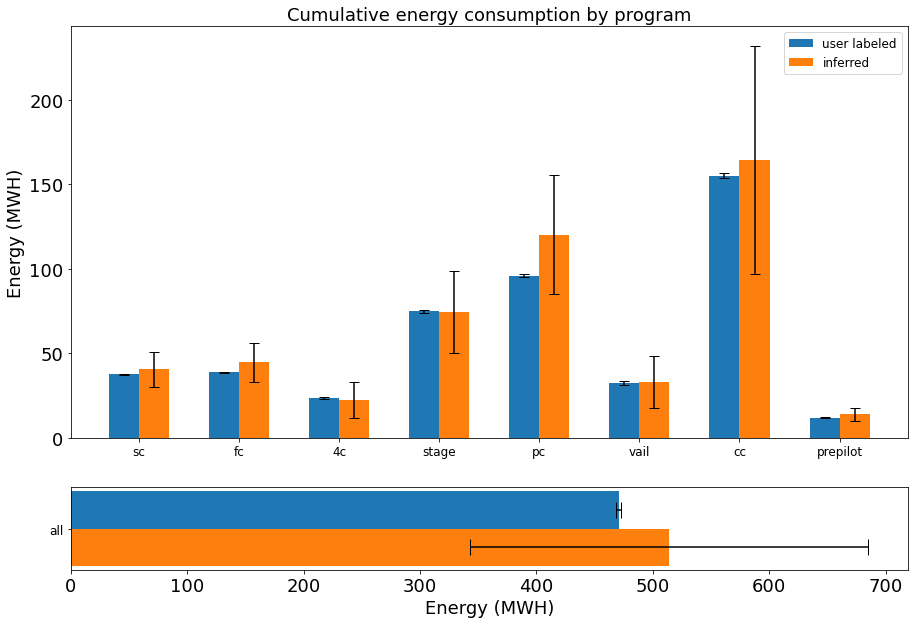

In [34]:
# Plot the bar chart
x_labels = list(df.program.unique())
n=len(x_labels)
x_range = np.arange(n)
width = 0.3
label_font_size = 18

fig, axs = plt.subplots(2,1,  gridspec_kw={'height_ratios': [5, 1]})

axs[0].bar(x_range, user_labeled_EC_list, yerr = user_sd_list, color = 'tab:blue', width = width, label= 'user labeled', capsize=5)
axs[0].bar(x_range + width, expected_EC_list, yerr = standard_deviation_list, color = 'tab:orange', width = width, label = 'inferred', capsize= 5)

axs[0].xaxis.set_tick_params(which='minor', labelsize=label_font_size)

#axs[0].set_xlabel("Program",fontsize = 14)
axs[0].set_ylabel("Energy (MWH)",fontsize = label_font_size)
#axs[0].set_title("Cumulative energy consumption by program from user labels vs from inferred labels", fontsize = 14)
axs[0].set_title("Cumulative energy consumption by program", fontsize = label_font_size)

# my version of pyplot doesn't have the option of labels in set_xticks
# axs[1].set_xticks.__doc__
axs[0].set_xticks(ticks = x_range + width/2)  
axs[0].set_xticklabels(x_labels, fontsize= 12)
axs[0].legend(prop={'size': 12})
plt.rcParams["figure.figsize"] = (15,10)

height = 0.05
y_range = np.array([0])
axs[1].barh(y_range, total_user_labeled, xerr = total_user_sd, height=height, capsize=8)
axs[1].barh(y_range - height, total_expected, xerr = sensed_sd, height=height, capsize=8)
axs[1].set_yticks(ticks = y_range - height/2)
axs[1].set_yticklabels(['all'], fontsize= 12)
axs[1].set_xlabel("Energy (MWH)",fontsize = label_font_size)
#axs[1].errorbar(sensed_sd, 0 + width)

plt.show()

# alternative display, one program per subplot: hf.plot_aggregate_EC_bar_chart(energy_consumption_from_sections_df)

In [ ]:
x_labels = list(df.program.unique())
n=len(x_labels)
x_range = np.arange(n)
width = 0.3
  
plt.bar(x_range, user_labeled_EC_list, yerr = user_sd_list, color = 'tab:blue', width = width, label= 'user labeled', capsize=5)
plt.bar(x_range + width, expected_EC_list, yerr = standard_deviation_list, color = 'tab:orange', width = width, label = 'inferred', capsize= 5)
  
plt.xlabel("Program",fontsize = 14)
plt.ylabel("Energy consumption (MWH)",fontsize = 14)
plt.title("Cumulative energy consumption by program from user labels vs from inferred labels",fontsize = 15)
  
plt.xticks(x_range + width/2, x_labels, fontsize= 12)
plt.legend(prop={'size': 12})
plt.rcParams["figure.figsize"] = (10,8)
plt.show()

# alternative display, one program per subplot: hf.plot_aggregate_EC_bar_chart(energy_consumption_from_sections_df)

### Energy consumption by actual mode

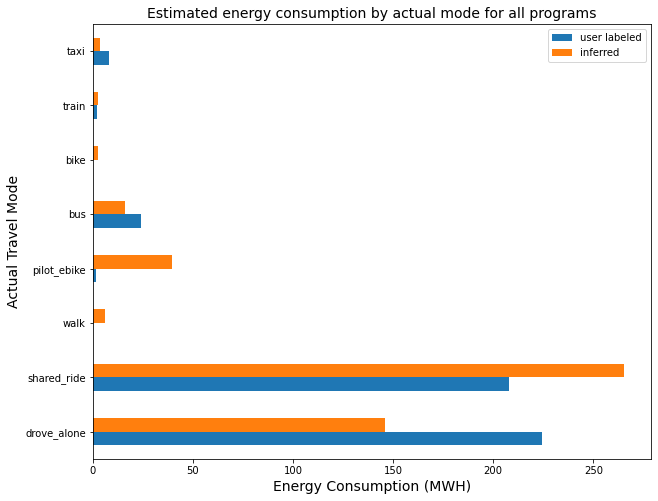

In [97]:
hf.plot_energy_consumption_by_mode(energy_consumption_from_sections_df, "all programs", main_mode_labels = ['drove_alone','shared_ride','walk','pilot_ebike','bus','bike','train','taxi'])

### Now try with a Bayes update.

In [ ]:
prior_probs = hf.construct_prior_dict({"Car, sensed": 0.85, "Pilot ebike": 0.05})

android_EI_moments_with_Bayes_update_df = cm_handling.get_Bayesian_conditional_EI_expectation_and_variance(android_confusion,energy_dict, prior_probs)
ios_EI_moments_with_Bayes_update_df = cm_handling.get_Bayesian_conditional_EI_expectation_and_variance(ios_confusion,energy_dict, prior_probs)
os_EI_moments_with_Bayes_update_map = {'ios': ios_EI_moments_with_Bayes_update_df, 'android': android_EI_moments_with_Bayes_update_df}
energy_consumption_with_Bayes_update_df = get_EC.compute_all_EC_values(expanded_labeled_trips,unit_dist_MCS_df,energy_dict,\
    android_EI_moments_with_Bayes_update_df,\
    ios_EI_moments_with_Bayes_update_df, \
    EI_length_cov, print_info=False)

In [ ]:
# Aggregate distance method
# This cell plots the user labeled and expected aggregate energy consumptions on the left and right, respectively. 
program_n_sd_map = hf.plot_estimates_with_sd_by_program(energy_consumption_with_Bayes_update_df,os_EI_moments_with_Bayes_update_map, unit_dist_MCS_df, variance_method='aggregate_distance')
print(f"number of standard deviations from mean: {program_n_sd_map}")

In [ ]:
# Spatial covariance method
program_n_sd_map = hf.plot_estimates_with_sd_by_program(energy_consumption_df,os_EI_moments_map,unit_dist_MCS_df,variance_method="aggregate_distance")
print(f"number of standard deviations from mean: {program_n_sd_map}")

### What are the proportions of each mode in mobilitynet?

In [ ]:
all_mobilitynet_trips = android_confusion + ios_confusion
durations_in_modes = all_mobilitynet_trips.sum(axis=1)
mobility_net_mode_proportions = durations_in_modes/all_mobilitynet_trips.sum().sum() #this gives the proportions of each mode in mobilitynet
print(mobility_net_mode_proportions.round(2).to_latex())

In [ ]:
mobility_net_mode_proportions

In [ ]:
# Demonstration that dividing each android confusion column by its column sum is 
# equivalent to assuming that the data has the same prior mode distribution as the android trips in mobility net
android_confusion = pd.read_csv("android_confusion.csv").set_index('gt_mode')#+ ios_confusion

durations_in_modes = android_confusion.sum(axis=1)
prior_mode_probs = durations_in_modes/all_mobilitynet_trips.sum().sum()

p_predicted_given_actual = android_confusion.divide(android_confusion.sum(axis=1), axis='rows')

likelihood_times_priors = p_predicted_given_actual.multiply(pd.Series(prior_mode_probs), axis='rows')
normalizing_constants = likelihood_times_priors.sum(axis='rows')
prob_actual_given_predicted_df = likelihood_times_priors.divide(normalizing_constants, axis='columns').copy()
prob_actual_given_predicted_df

In [ ]:
ios_confusion = pd.read_csv("ios_confusion.csv").set_index('gt_mode')
android_confusion = pd.read_csv("android_confusion.csv").set_index('gt_mode')#+ ios_confusion

all_mobilitynet_trips = android_confusion + ios_confusion
durations_in_modes = all_mobilitynet_trips.sum(axis=1)
prior_mode_probs = durations_in_modes/all_mobilitynet_trips.sum().sum()

p_predicted_given_actual = android_confusion.divide(android_confusion.sum(axis=1), axis='rows')

likelihood_times_priors = p_predicted_given_actual.multiply(pd.Series(prior_mode_probs), axis='rows')
normalizing_constants = likelihood_times_priors.sum(axis='rows')
prob_actual_given_predicted_df = likelihood_times_priors.divide(normalizing_constants, axis='columns').copy()
prob_actual_given_predicted_df

In [ ]:
def plot_energy_consumption_by_mode(energy_consumption_df,program_name, main_mode_labels = ['drove_alone','shared_ride','walk','pilot_ebike','bus','bike','train','taxi','free_shuttle']):
    df = energy_consumption_df.copy()
    program_main_mode_labels = [x for x in main_mode_labels if x in df.mode_confirm.unique()] # 4c doesn't have train before May 2022.

    program_main_modes_EC = df.groupby('mode_confirm').sum().loc[program_main_mode_labels]
    program_main_modes_EC = program_main_modes_EC[['expected','user_labeled']] # 'predicted',

    program_main_modes_EC.plot(kind='barh')
    program_percent_error_expected = 100*hf.relative_error(df.expected.sum(),df.user_labeled.sum())
    plt.xlabel('Energy consumption (kWH)')
    plt.ylabel('user labeled mode')
    plt.title(f"Energy consumption estimates by user labeled mode for {program_name}\nCustom mode labels not shown\n(full % error for expected: {program_percent_error_expected:.2f})")

plot_energy_consumption_by_mode(energy_consumption_from_sections_df,'all CEO + stage', main_mode_labels = ['drove_alone','shared_ride','walk','pilot_ebike','bus','bike','train','taxi','free_shuttle'])

In [ ]:
# what percent of all ceo trips are ebike?
expanded_labeled_trips.groupby('mode_confirm').sum()['distance']['pilot_ebike']/expanded_labeled_trips.distance.sum()

### Calculate variance with sections or calculate mean with primary mode.
Distance in each mode gets distributed differently if you look at primary mode instead of sections

In [ ]:
var_based_on_sections, distance_in_mode = get_EC.compute_aggregate_variance_with_total_distance_from_sections(expanded_labeled_trips, os_EI_moments_map, unit_dist_MCS_df)

# the version that I've been using takes the total distance in miles for the trip and groups by primary mode.
var_based_on_primary_modes = get_EC.compute_aggregate_variance(expanded_labeled_trips, os_EI_moments_map, unit_dist_MCS_df)
np.sqrt(var_based_on_sections), np.sqrt(var_based_on_primary_modes)

In [ ]:
round(sum(distance_in_mode['android'].values()) + sum(distance_in_mode['ios'].values()),2), round(expanded_labeled_trips.distance_miles.sum(),2)

In [ ]:
def get_primary_mode_distance_vs_section_distance_df(expanded_labeled_trips, distance_in_mode, os):

    primary_distances= expanded_labeled_trips[expanded_labeled_trips.os == os].groupby("primary_mode").distance_miles.sum()
    primary_vs_section_df = pd.DataFrame(primary_distances)

    primary_vs_section_df["section_based_distance"] = primary_vs_section_df.index.map(distance_in_mode[os])
    return primary_vs_section_df

get_primary_mode_distance_vs_section_distance_df(expanded_labeled_trips,distance_in_mode, "android").round(2)

In [ ]:
get_primary_mode_distance_vs_section_distance_df(expanded_labeled_trips,distance_in_mode, "ios").round(2)

In [ ]:
primary_mode_energy_df = get_EC.compute_all_EC_values_from_primary_mode(expanded_labeled_trips,unit_dist_MCS_df,energy_dict, android_EI_moments_df,ios_EI_moments_df)
primary_mode_energy_df.expected.sum(), energy_consumption_df.expected.sum()

In [ ]:
energy_consumption_df['primary_expected'] = primary_mode_energy_df.expected
energy_consumption_df[['user_labeled', 'expected','primary_expected', 'section_modes', 'mode_confirm','section_distances', 'distance' ]]

### What happens with a modeshare approach?
The resulting variance is very large.

In [ ]:
#def calculate_EC_by_mode_share(df,android_confusion,ios_confusion)

# 1. split into android and ios dataframes
# 2. compute for each.
import itertools

# find a matrix of prob predicted given actual.
collapsed_confusion_matrix = cm_handling.collapse_confusion_matrix(android_confusion, rows_to_collapse={"Train": ["Train"]}, columns_to_collapse={})
duration_sensed_as_car_given_actual_ebike = 0.4*collapsed_confusion_matrix.loc['Pilot ebike'].sum()
collapsed_confusion_matrix.at['Pilot ebike','bicycling'] -=duration_sensed_as_car_given_actual_ebike
collapsed_confusion_matrix.at['Pilot ebike','car'] += duration_sensed_as_car_given_actual_ebike
prob_actual_given_predicted_df = collapsed_confusion_matrix/collapsed_confusion_matrix.sum(axis=0)

sensed_mode_distances = energy_consumption_df.groupby("primary_mode").sum().distance_miles

expected_EC = 0
var_EC = 0
primary_mode_distance_estimates = {}
primary_mode_dist_sd_estimates = {}
for primary_mode in sensed_mode_distances.index:
    if primary_mode == 'air_or_hsr':
        primary_mode = 'train'
    primary_mode_distance_estimates[primary_mode] = 0
    var_primary_mode_total = 0
    for gt_mode in prob_actual_given_predicted_df.index:
        prob_gt_mode = prob_actual_given_predicted_df.loc[gt_mode][primary_mode]
        expected_distance = prob_gt_mode * sensed_mode_distances[primary_mode] * 1.04  # 1.04 is from unit dist MCS

        primary_mode_distance_estimates[primary_mode] += expected_distance        

        # n = len(expanded_labeled_trips[expanded_labeled_trips.primary_mode == primary_mode])*
        var_in_mode_distance = prob_gt_mode*(1 - prob_gt_mode)*sensed_mode_distances[primary_mode]**2

        var_primary_mode_total += var_in_mode_distance    
        expected_EC += energy_dict[MODE_MAPPING_DICT[primary_mode]]*expected_distance

        var_EC += var_in_mode_distance #*energy_dict[MODE_MAPPING_DICT[primary_mode]]**2


    primary_mode_dist_sd_estimates[primary_mode] = np.sqrt(var_primary_mode_total)
print(f"Expected, user labeled {expected_EC:.2f}, {energy_consumption_df.user_labeled.sum():.2f}")
print(f"sd: {np.sqrt(var_EC):.2f}")
# Based on this, using mode share by distance for EC is not great.